In [1]:
import re
import os
import string
import unicodedata

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from nltk.stem.porter import PorterStemmer
from nltk.corpus import words
word_dict = words.words()
stemmer = PorterStemmer()

# Read data

In [2]:
train_df = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
test_df = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')
print('Train dataset shape:', train_df.shape)
print('Test dataset shape:', test_df.shape)

Train dataset shape: (7613, 5)
Test dataset shape: (3263, 4)


In [3]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


# Missing values

In [4]:
def print_missing_values(df, name):
    print(f'Missing values in { name}')
    for col in df.columns:
        col_missing = df[col].isna().sum()
        print(f'{col}: {100*col_missing/len(df):.2f}%',)
    print()
print_missing_values(train_df, 'Training dataset')
print_missing_values(test_df, 'Test dataset')

Missing values in Training dataset
id: 0.00%
keyword: 0.80%
location: 33.27%
text: 0.00%
target: 0.00%

Missing values in Test dataset
id: 0.00%
keyword: 0.80%
location: 33.86%
text: 0.00%



In [5]:
train_df = train_df.fillna('unk')
test_df = test_df.fillna('unk')

# Duplicated values

In [6]:
cols = ['text', 'target', 'keyword', 'location']
dups_df = train_df[train_df.duplicated(subset = cols,)].sort_values(by = cols)
print(f'There is {len(dups_df)} duplicated records in training dataset.')

cols = ['text', 'keyword', 'location']
dups_df = test_df[test_df.duplicated(subset = cols,)].sort_values(by = cols)
print(f'There is {len(dups_df)} duplicated records in test dataset.')

There is 52 duplicated records in training dataset.
There is 11 duplicated records in test dataset.


We should remove those duplicated records from training set.

In [7]:
cols = ['text', 'target', 'keyword', 'location']
train_df = train_df.drop_duplicates(cols).reset_index(drop = True)

## Duplicated text

In [8]:
cols = ['text']
dups_df = train_df[train_df.duplicated(subset = cols)].sort_values(by = cols)
print(f'There is {len(dups_df)} duplicated tweets in training dataset.')
dups_df = dups_df.groupby(cols).agg({
    'id':'count',
    'keyword': 'nunique',
    'target': 'nunique',
    'location': 'nunique',
}).reset_index().rename(columns = {'id': 'text_dup_times'})
dups_df.groupby('text_dup_times').agg({
    'keyword': 'sum',
    'target': 'sum',
    'location': 'sum',
}).reset_index()

There is 58 duplicated tweets in training dataset.


,text_dup_times,keyword,target,location
0,1,40,40,40
1,2,7,11,14
2,4,1,1,4


**It looks to me that:**
* When the same tweet is duplicated 4 time, it refers to disaster/not disaster with the same keyword in 4 locations (this can't be true). those duplicated tweets should be deleted
* When the same tweet is duplicated 2 or 1 time, it was classified as disaster sometimes and sometimes as not a disastor. This is also noise in the data. We should delete those records but we should be careful about the label. We can elelmiate those duplicated tweets by voting on thier labels

In [9]:
train_df = train_df.groupby(by = ['text']).agg({
    'id': 'first',
    'location': lambda x:x.value_counts().index[0],
    'keyword':lambda x:x.value_counts().index[0],
    'target': lambda x:x.value_counts().index[0],
}).reset_index()

# Target Column

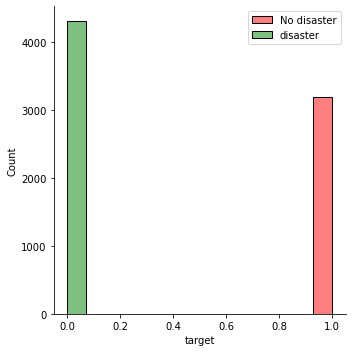

In [10]:
sns.displot(x = 'target', hue = 'target', data = train_df, palette = ['green', 'red'], legend = False)
plt.legend(['No disaster', 'disaster'])
plt.show()

# Location Column

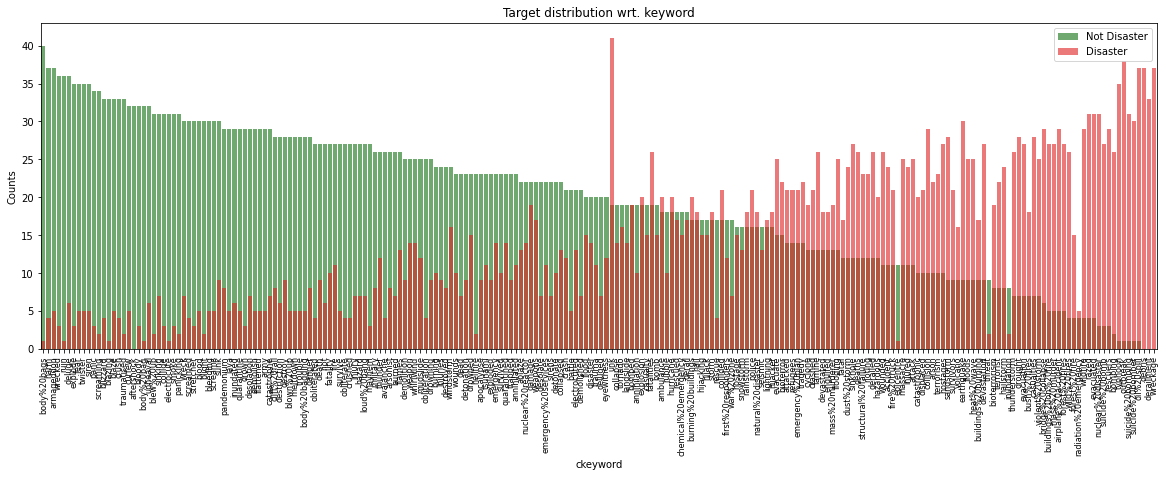

In [11]:
df = pd.pivot_table(train_df, index = ['keyword'], columns = ['target'], values = 'id', aggfunc = 'count', fill_value = 0 ).reset_index()
df = df.sort_values(by = [0], ascending = False)
plt.figure(figsize = (20, 6))
sns.barplot(y = 0, x = 'keyword', data = df, color = "g", alpha = 0.6, label = 'Not Disaster')
sns.barplot(y = 1, x = 'keyword', data = df, color = 'r', alpha = 0.6, label = 'Disaster')
plt.title('Target distribution wrt. keyword')
plt.xlabel('ckeyword')
plt.ylabel('Counts')
plt.xticks(rotation = 90, fontsize = 8)
plt.legend()

In [12]:
train_df['keyword'].value_counts()[0: 20]

unk            60
fatalities     45
armageddon     42
deluge         42
damage         41
body%20bags    41
harm           41
siren          40
windstorm      40
twister        40
fear           40
evacuate       40
sunk           39
whirlwind      39
outbreak       39
flames         39
wrecked        39
sinkhole       39
weapons        39
collision      39
Name: keyword, dtype: int64

# Location Column

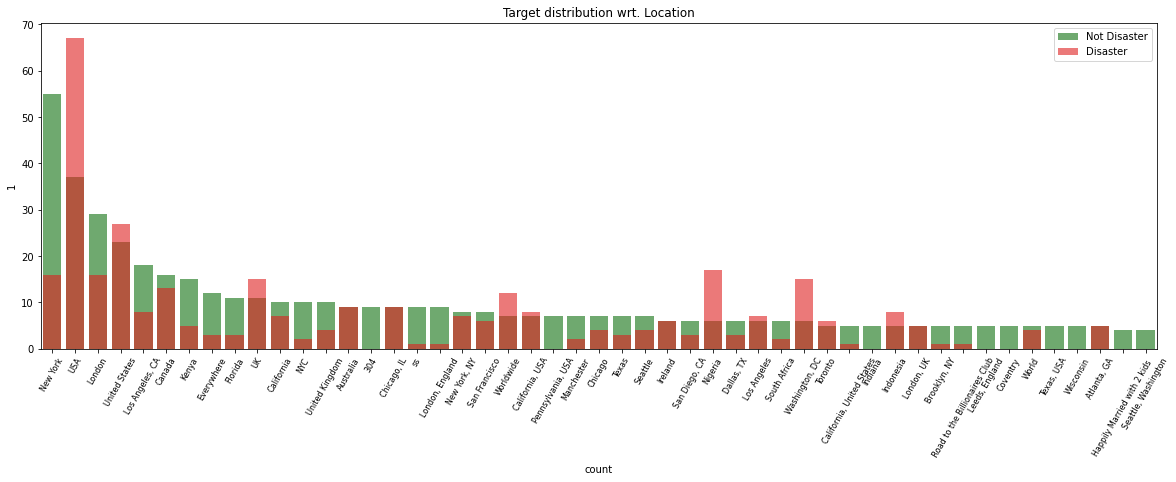

In [13]:
df = pd.pivot_table(train_df, index = 'location', columns = 'target', values = 'id', aggfunc = 'count', fill_value = 0).reset_index()
df = df.sort_values(by = 0, ascending = False)
lim = 50
plt.figure(figsize = (20, 6))
sns.barplot(x = 'location', y = 0, data = df.iloc[1:lim], color = 'g', alpha = 0.6, label = 'Not Disaster')
sns.barplot(x = 'location', y = 1, data = df.iloc[1:lim], color = 'r', alpha = 0.6, label = 'Disaster')
plt.xlabel('count')
plt.title('Target distribution wrt. Location')
plt.xticks(rotation = 60, fontsize = 8)
plt.legend()
plt.show()

In [14]:
train_df['location'].value_counts()[0:20]

unk                2481
USA                 104
New York             71
United States        50
London               45
Canada               29
Los Angeles, CA      26
UK                   26
Nigeria              23
Washington, DC       21
India                21
Mumbai               21
Kenya                20
Worldwide            19
Australia            18
Chicago, IL          18
California           17
Everywhere           15
New York, NY         15
California, USA      15
Name: location, dtype: int64

# Text Column

## Text cleaning

In [15]:
train_df['ctext'] = train_df['text'].copy()

def clean_txt(txt):
    # normalizing the text
    res = unicodedata.normalize('NFKC', txt)
    # remove non_printable characters
    res = re.sub(r'[^\x00-\x7F]+', r'', res)
    # remove retweet chars
    res = re.sub(r'^RT[\s]+', r'', res)
    # remove stock market tiker
    res = re.sub(r'\$\w*', r'', res)
    # replalce less, greater, and chars
    res = re.sub(r'&lt;', r'<', res)
    res = re.sub(r'&gt;', r'>', res)
    res = re.sub(r'&amp;?', r'and', res)
    # remove html tags
    res = re.sub(r'<[^>]*?>', r'', res)
    # separate contected hashtags
    res = re.sub(r'#', r' #', res)
    res = re.sub(r'\s#\s', r' ', res)
    return res

train_df['ctext'] = train_df['ctext'].apply(clean_txt )

### Delete Urls

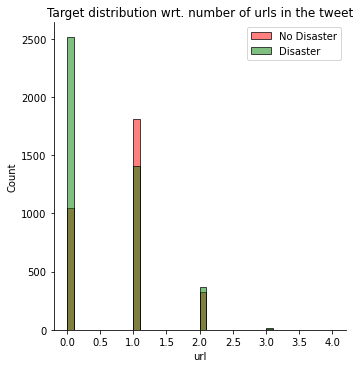

In [16]:
regex = r'http\S+|www\.\S+'
sub_str = r' website '
def apply_regex(txt, regex, sub_str):
    matches = re.findall(regex, txt)
    if matches:
        ctxt = re.sub(regex, sub_str, txt)
        return ctxt, len(matches)
    else:
        return txt, 0
res = train_df['ctext'].apply(apply_regex, args = [regex, sub_str],)
train_df['ctext'] = res.apply(lambda t:t[0])
train_df['url'] = res.apply(lambda t:t[1])
sns.displot(x = 'url', hue = 'target', data = train_df, palette = ['g', 'r'], kind = 'hist', legend = False)
plt.legend(['No Disaster', 'Disaster'])
plt.title('Target distribution wrt. number of urls in the tweet')
plt.show()

* When people share no urls in the tweet, it is more likely to be not about a disastor
* When people share one url in the tweet, it is more likely to be about a disaster


### Hash tags and mentions

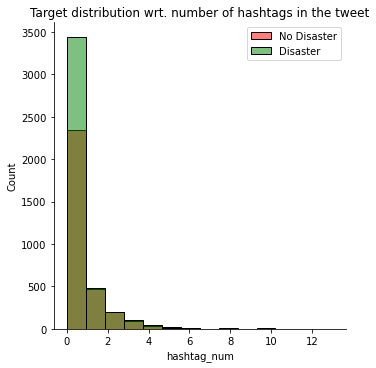

In [17]:
def validate_hashtag(hashtags):
    res = []
    for hashtag in hashtags:
        valid = re.findall(r'[a-zA-Z]+', hashtag)
        if valid:
            res.append(re.sub(r'[^\w]*', r'', hashtag).lower())
        else:
            res.append('unk')
    return res

def extract_hashtags(txt):
    regex = r'#+\s*\S+'
    hash_tag_matches = re.findall(regex, txt)
    if hash_tag_matches:
        ctxt = re.sub(r'#+\s*(?P<hash>\S+)', r'\g<hash>', txt)
        validated_hash = list(set(validate_hashtag(hash_tag_matches)))
        return ctxt, len(validated_hash), validated_hash
    else:
        return txt, 0, ['none']

res = train_df['ctext'].apply(extract_hashtags)
train_df['ctext'] = res.apply(lambda t:t[0])
train_df['hashtag_num'] = res.apply(lambda t:t[1])
train_df['hashtags'] = res.apply(lambda t:t[2])
sns.displot(x = 'hashtag_num', hue = 'target', data = train_df, palette = ['g', 'r'], kind = 'hist', legend = False)
plt.legend(['No Disaster', 'Disaster'])
plt.title('Target distribution wrt. number of hashtags in the tweet')
plt.show()

## How many words do exist in the dictionay

In [18]:

txt = ' '.join(train_df.ctext.values)
txt = re.sub(r'[%s]' % re.escape(string.punctuation), r' ', txt)
txt = re.sub(r'\s+', r' ', txt)
tokens = set(txt.split())
word_dict = set(word_dict)
not_word_tokens = tokens - tokens.intersection(word_dict)

print(f'Tweets contain unknown words: {100 * len(not_word_tokens) / len(tokens):.2f}%')

Tweets contain unknown words: 71.64%


In [19]:
tokens = set([stemmer.stem(w) for w in txt.split()])
word_dict = set(word_dict)
not_word_tokens = tokens - tokens.intersection(word_dict)

print(f'After stemming! Tweets contain unknown words: {100 * len(not_word_tokens) / len(tokens):.2f}%')

After stemming! Tweets contain unknown words: 69.92%


In [20]:
list(not_word_tokens)[:30]

['sharpli',
 'mthe',
 'phnotf',
 'choppa',
 'chandane',
 'sportwatch',
 'djicemoon',
 'amiddl',
 'ND',
 'mh17',
 'fairli',
 'manslaught',
 'ireport',
 'bentley',
 'infrastructur',
 'richard',
 'alot',
 'kylekrenek',
 'jeez',
 'bjpsamvad',
 'fav',
 'vixstuart',
 'itsnasb',
 'koz',
 'printabl',
 'parentsacrossam',
 '22',
 'mmmmmm',
 'taungbazar',
 'spokan']

Unknown word exists due to:
* stemming errors
* name of places
* name of persons
* missplelling
* concatenated words
* abbreviations 
* ...